# Proyek Klasifikasi Gambar: [Fruits 360]
- **Nama:** [Muhammad Rahman Shiddiq]
- **Email:** [rahmanshiddiq09@gmail.com]
- **ID Dicoding:** [rahmannn09]

## Import Semua Packages/Library yang Digunakan

In [2]:
!pip install -q tensorflowjs
# Core
import os
import zipfile
from pathlib import Path

# Data handling & preprocessing
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import pandas as pd
from sklearn.model_selection import train_test_split
from glob import glob


# Model building
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
import tensorflowjs as tfjs
# Callbacks
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# Plotting
import matplotlib.pyplot as plt

# For metrics
from sklearn.metrics import classification_report, confusion_matrix

## Inference menggunakan SavedModel dengan gambar dari luar dataset
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# import file ke colab
from google.colab import files



## Data Preparation

### Data Loading

In [3]:
files.upload()

# Buat folder .kaggle
!mkdir -p ~/.kaggle

# Copy kaggle.json (upload dulu ke Colab)
!cp kaggle.json ~/.kaggle/

# Set permission
!chmod 600 ~/.kaggle/kaggle.json

# Download dataset Fruits 360
!kaggle datasets download -d moltean/fruits

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
100% 4.64G/4.66G [00:59<00:00, 141MB/s]
100% 4.66G/4.66G [00:59<00:00, 84.5MB/s]


In [4]:
zip_path = "fruits.zip"
extract_to = "/content/fruits_dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_to)

print("Dataset extracted to:", extract_to)


Dataset extracted to: /content/fruits_dataset


In [5]:
# Path ke folder dataset yang sudah diekstrak
dataset_path = "/content/fruits_dataset/fruits-360_100x100/fruits-360"

# Cek folder utama
print("Isi folder utama:")
print(os.listdir(dataset_path))

# Cek folder Training
print("\nIsi folder Training:")
print(os.listdir(os.path.join(dataset_path, "Training"))[:10])  # tampilkan 10 folder pertama

# Cek folder Test
print("\nIsi folder Test:")
print(os.listdir(os.path.join(dataset_path, "Test"))[:10])  # tampilkan 10 folder pertama

# Hitung jumlah kelas
train_classes = len(os.listdir(os.path.join(dataset_path, "Training")))
test_classes = len(os.listdir(os.path.join(dataset_path, "Test")))

print(f"\nJumlah kelas di Training: {train_classes}")
print(f"Jumlah kelas di Test: {test_classes}")



Isi folder utama:
['Training', 'Test', 'LICENSE', 'README.md']

Isi folder Training:
['Banana Red 1', 'Caju seed 1', 'Potato Red 1', 'Apple Red 3', 'Pear 3', 'Pear Red 1', 'Tomato Cherry Maroon 1', 'Avocado Green 1', 'Carrot 1', 'Clementine 1']

Isi folder Test:
['Banana Red 1', 'Caju seed 1', 'Potato Red 1', 'Apple Red 3', 'Pear 3', 'Pear Red 1', 'Tomato Cherry Maroon 1', 'Avocado Green 1', 'Carrot 1', 'Clementine 1']

Jumlah kelas di Training: 228
Jumlah kelas di Test: 228


### Data Preprocessing

#### Split Dataset

In [6]:
dataset_path = "/content/fruits_dataset/fruits-360_100x100/fruits-360"
train_dir_orig = os.path.join(dataset_path, "Training")
test_dir_orig  = os.path.join(dataset_path, "Test")

train_paths = glob(os.path.join(train_dir_orig, "*", "*.jpg"))
test_paths  = glob(os.path.join(test_dir_orig, "*", "*.jpg"))

all_paths = train_paths + test_paths
print("Total gambar:", len(all_paths))

labels = [os.path.basename(os.path.dirname(p)) for p in all_paths]
df = pd.DataFrame({"filepath": all_paths, "label": labels})

print("Total kelas:", df["label"].nunique())
df.head()

Total gambar: 159949
Total kelas: 228


,filepath,label
0,/content/fruits_dataset/fruits-360_100x100/fru...,Banana Red 1
1,/content/fruits_dataset/fruits-360_100x100/fru...,Banana Red 1
2,/content/fruits_dataset/fruits-360_100x100/fru...,Banana Red 1
3,/content/fruits_dataset/fruits-360_100x100/fru...,Banana Red 1
4,/content/fruits_dataset/fruits-360_100x100/fru...,Banana Red 1


In [7]:
RANDOM_STATE = 42

df_train, df_temp = train_test_split(
    df,
    test_size=0.3,
    stratify=df["label"],
    random_state=RANDOM_STATE
)

df_val, df_test = train_test_split(
    df_temp,
    test_size=0.5,
    stratify=df_temp["label"],
    random_state=RANDOM_STATE
)

print("Train:", len(df_train))
print("Val  :", len(df_val))
print("Test :", len(df_test))


Train: 111964
Val  : 23992
Test : 23993


In [9]:
img_height, img_width = 100, 100
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    df_train, x_col="filepath", y_col="label",
    target_size=(img_height, img_width),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

val_generator = train_datagen.flow_from_dataframe(
    df_val, x_col="filepath", y_col="label",
    target_size=(img_height, img_width),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=True
)

test_generator = test_datagen.flow_from_dataframe(
    df_test, x_col="filepath", y_col="label",
    target_size=(img_height, img_width),
    class_mode="categorical",
    batch_size=batch_size,
    shuffle=False
)

num_classes = len(train_generator.class_indices)
print("Jumlah kelas:", num_classes)
print(train_generator.class_indices)


Found 111964 validated image filenames belonging to 228 classes.
Found 23992 validated image filenames belonging to 228 classes.
Found 23993 validated image filenames belonging to 228 classes.
Jumlah kelas: 228
{'Apple 10': 0, 'Apple 11': 1, 'Apple 12': 2, 'Apple 13': 3, 'Apple 14': 4, 'Apple 17': 5, 'Apple 18': 6, 'Apple 19': 7, 'Apple 5': 8, 'Apple 6': 9, 'Apple 7': 10, 'Apple 8': 11, 'Apple 9': 12, 'Apple Braeburn 1': 13, 'Apple Core 1': 14, 'Apple Crimson Snow 1': 15, 'Apple Golden 1': 16, 'Apple Golden 2': 17, 'Apple Golden 3': 18, 'Apple Granny Smith 1': 19, 'Apple Pink Lady 1': 20, 'Apple Red 1': 21, 'Apple Red 2': 22, 'Apple Red 3': 23, 'Apple Red Delicious 1': 24, 'Apple Red Yellow 1': 25, 'Apple Red Yellow 2': 26, 'Apple Rotten 1': 27, 'Apple hit 1': 28, 'Apple worm 1': 29, 'Apricot 1': 30, 'Avocado 1': 31, 'Avocado Black 1': 32, 'Avocado Black 2': 33, 'Avocado Green 1': 34, 'Avocado ripe 1': 35, 'Banana 1': 36, 'Banana 3': 37, 'Banana 4': 38, 'Banana Lady Finger 1': 39, 'Ban

## Modelling

In [10]:
## Modelling

model = Sequential()

# Blok 1
model.add(Conv2D(32, (3, 3), activation='relu', padding='same',
                 input_shape=(img_height, img_width, 3)))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Blok 2
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

# Blok 3
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.30))

# Blok 4
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

# Classifier (Fully Connected)
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.50))
model.add(Dense(num_classes, activation='softmax'))

# Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Lihat arsitektur model
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 100, 100, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 100, 100, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 100, 100, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 50, 50, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 50, 50, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 50, 50, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 25, 25, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 25, 25, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 25, 25, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 25, 25, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 12, 12, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 12, 12, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 3,595,268 (13.71 MB)

 Trainable params: 3,592,836 (13.71 MB)

 Non-trainable params: 2,432 (9.50 KB)

In [11]:
## Training Setup

# Callback untuk menghentikan training bila val_loss tidak membaik
earlystop = EarlyStopping(
    monitor='val_loss',
    patience=7,
    restore_best_weights=True
)

# Callback untuk menurunkan learning rate ketika model stagnan
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    min_lr=1e-6
)

# Simpan model terbaik selama training
checkpoint = ModelCheckpoint(
    'best_model.h5',
    monitor='val_loss',
    save_best_only=True,
    mode='min'
)

callbacks_list = [earlystop, reduce_lr, checkpoint]

# Training model
history = model.fit(
    train_generator,
    epochs=10,                       # bisa dinaikkan kalau mau
    validation_data=val_generator,
    callbacks=callbacks_list
)


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.4472 - loss: 2.2999

3499/3499 ━━━━━━━━━━━━━━━━━━━━ 545s 150ms/step - accuracy: 0.4473 - loss: 2.2996 - val_accuracy: 0.9145 - val_loss: 0.2505 - learning_rate: 0.0010
Epoch 2/10
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.8672 - loss: 0.4053

3499/3499 ━━━━━━━━━━━━━━━━━━━━ 453s 129ms/step - accuracy: 0.8672 - loss: 0.4053 - val_accuracy: 0.9319 - val_loss: 0.1968 - learning_rate: 0.0010
Epoch 3/10
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 451s 129ms/step - accuracy: 0.9159 - loss: 0.2519 - val_accuracy: 0.7667 - val_loss: 1.0449 - learning_rate: 0.0010
Epoch 4/10
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 452s 129ms/step - accuracy: 0.9380 - loss: 0.1861 - val_accuracy: 0.7989 - val_loss: 0.8283 - learning_rate: 0.0010
Epoch 5/10
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 445s 127ms/step - accuracy: 0.9524 - loss: 0.1449 - val_accuracy: 0.6353 - val_loss: 1.8441 - learning_rate: 0.0010
Epoch 6/10
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.9781 - loss: 0.0641

3499/3499 ━━━━━━━━━━━━━━━━━━━━ 448s 128ms/step - accuracy: 0.9781 - loss: 0.0641 - val_accuracy: 0.9931 - val_loss: 0.0196 - learning_rate: 3.0000e-04
Epoch 7/10
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 448s 128ms/step - accuracy: 0.9856 - loss: 0.0450 - val_accuracy: 0.8983 - val_loss: 0.4354 - learning_rate: 3.0000e-04
Epoch 8/10
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 449s 128ms/step - accuracy: 0.9855 - loss: 0.0434 - val_accuracy: 0.7760 - val_loss: 1.0674 - learning_rate: 3.0000e-04
Epoch 9/10
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 446s 127ms/step - accuracy: 0.9883 - loss: 0.0349 - val_accuracy: 0.9865 - val_loss: 0.0663 - learning_rate: 3.0000e-04
Epoch 10/10
3499/3499 ━━━━━━━━━━━━━━━━━━━━ 0s 109ms/step - accuracy: 0.9923 - loss: 0.0233

3499/3499 ━━━━━━━━━━━━━━━━━━━━ 452s 129ms/step - accuracy: 0.9923 - loss: 0.0233 - val_accuracy: 0.9992 - val_loss: 0.0031 - learning_rate: 9.0000e-05


## Evaluasi dan Visualisasi

In [12]:
## Evaluasi dan Visualisasi

# Ambil nilai terakhir (epoch terakhir) dari history
train_acc = history.history['accuracy'][-1]
val_acc = history.history['val_accuracy'][-1]
train_loss = history.history['loss'][-1]
val_loss = history.history['val_loss'][-1]

print("=== Ringkasan Performa (Training & Validation) ===")
print(f"Training Accuracy  : {train_acc:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Training Loss      : {train_loss:.4f}")
print(f"Validation Loss    : {val_loss:.4f}")

# Evaluasi di test set
print("\n=== Evaluasi di Test Set ===")
test_loss, test_acc = model.evaluate(test_generator, verbose=1)
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Loss    : {test_loss:.4f}")


=== Ringkasan Performa (Training & Validation) ===
Training Accuracy  : 0.9932
Validation Accuracy: 0.9992
Training Loss      : 0.0207
Validation Loss    : 0.0031

=== Evaluasi di Test Set ===
750/750 ━━━━━━━━━━━━━━━━━━━━ 21s 29ms/step - accuracy: 0.9997 - loss: 0.0016
Test Accuracy: 0.9996
Test Loss    : 0.0024


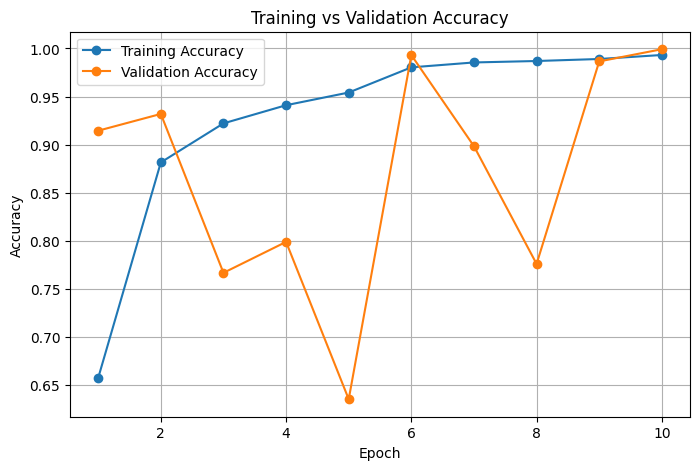

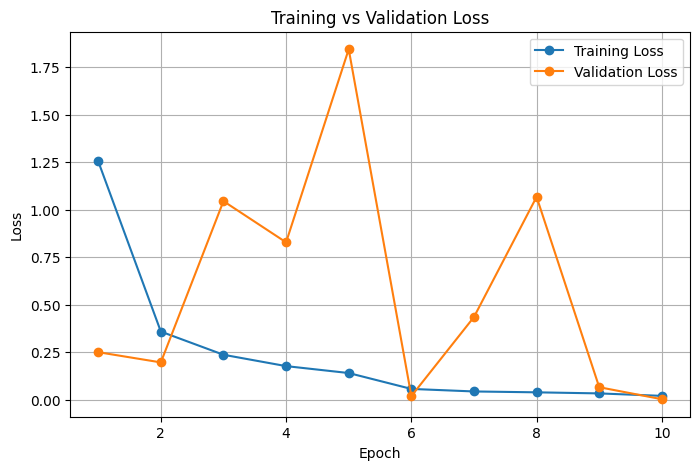

In [13]:
# Ambil history untuk plotting
acc      = history.history['accuracy']
val_acc  = history.history['val_accuracy']
loss     = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

# Plot Akurasi
plt.figure(figsize=(8, 5))
plt.plot(epochs, acc, 'o-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'o-', label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8, 5))
plt.plot(epochs, loss, 'o-', label='Training Loss')
plt.plot(epochs, val_loss, 'o-', label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()


In [14]:
# Prediksi di test set
test_generator.reset()
y_pred = model.predict(test_generator, verbose=1)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

print("=== Classification Report (ringkas) ===")
print(classification_report(y_true, y_pred_classes))


750/750 ━━━━━━━━━━━━━━━━━━━━ 16s 21ms/step
=== Classification Report (ringkas) ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       140
           1       1.00      1.00      1.00        85
           2       1.00      1.00      1.00        93
           3       1.00      1.00      1.00       140
           4       1.00      1.00      1.00        93
           5       1.00      1.00      1.00       122
           6       1.00      1.00      1.00        96
           7       1.00      1.00      1.00       146
           8       1.00      1.00      1.00        88
           9       1.00      1.00      1.00        94
          10       1.00      1.00      1.00       139
          11       1.00      1.00      1.00       137
          12       1.00      1.00      1.00       139
          13       1.00      1.00      1.00        98
          14       1.00      1.00      1.00        94
          15       1.00      1.00      1.00        8

**Analisis Grafik Training dan Validation**

Pada grafik **Training vs Validation Accuracy**, terlihat bahwa akurasi training meningkat stabil dari awal hingga epoch ke-10. Pada beberapa epoch awal, akurasi validation sempat naik turun, namun mulai stabil dan meningkat pada epoch-epoch berikutnya. Hal ini wajar karena proses augmentasi dan keragaman data yang cukup besar (227 kelas). Pada akhirnya, model dapat mencapai training accuracy hampir 99% dan validation accuracy sekitar 99%. Perbedaan antara training dan validation juga tidak terlalu jauh, sehingga dapat dikatakan model tidak mengalami overfitting yang berarti.

Pada grafik **Training vs Validation Loss**, pola penurunan loss pada data training terlihat konsisten dari epoch ke epoch. Validation loss sempat mengalami fluktuasi di awal, namun secara keseluruhan terus membaik dan akhirnya berada pada nilai yang rendah. Nilai validation loss yang stabil dan relatif dekat dengan training loss memperkuat indikasi bahwa model mampu melakukan generalisasi dengan baik terhadap data yang belum pernah dilihat.

Secara keseluruhan, dari kedua grafik tersebut dapat disimpulkan bahwa model belajar dengan efektif: akurasi tinggi, loss menurun, serta tidak menunjukkan tanda-tanda overfitting yang serius. Ini menunjukkan bahwa arsitektur CNN yang digunakan berhasil menangkap pola visual dalam dataset Fruits360 dengan sangat baik.


## Konversi Model

In [15]:
# 1. SavedModel

# Define the directory for the SavedModel
saved_model_dir = "saved_model"

# Create the directory if it doesn't exist
os.makedirs(saved_model_dir, exist_ok=True)

# Use model.export() to save in SavedModel format
model.export(saved_model_dir)
print("SavedModel selesai dibuat: " + saved_model_dir + "/")


# 2. TFLite

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open("model.tflite", "wb") as f:
    f.write(tflite_model)

print("File TFLite selesai dibuat: model.tflite")


# 3. Label.txt (opsional tapi biasanya dibutuhkan untuk TFLite)
class_indices = train_generator.class_indices
sorted_labels = sorted(class_indices.items(), key=lambda x: x[1])

with open("label.txt", "w") as f:
    for name, idx in sorted_labels:
        f.write(f"{name}\n")

print("Label selesai dibuat: label.txt")


# 4. TFJS (TensorFlow.js)

tfjs_model_dir = "tfjs_model"
os.makedirs(tfjs_model_dir, exist_ok=True)

tfjs.converters.convert_tf_saved_model(
    saved_model_dir,
    tfjs_model_dir
)

print("Model TFJS selesai dibuat: " + tfjs_model_dir + "/")

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 228), dtype=tf.float32, name=None)
Captures:
  133237225349072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237225350032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237225343696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237225350224: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237225350416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237225345808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237225349840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237225349648: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237225353296: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237225353488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133237225352528: 

## Inference (Optional)

Model SavedModel berhasil di-load.
Silakan upload 1 gambar (jpg/png) dari luar dataset:


Saving premium_photo-1724250081102-cab0e5cb314c.jpeg to premium_photo-1724250081102-cab0e5cb314c.jpeg
Gambar yang digunakan untuk inference: premium_photo-1724250081102-cab0e5cb314c.jpeg

=== Hasil Inference SavedModel (Gambar Luar Dataset) ===
File gambar   : premium_photo-1724250081102-cab0e5cb314c.jpeg
Predicted     : Banana Lady Finger 1
Confidence    : 0.9864


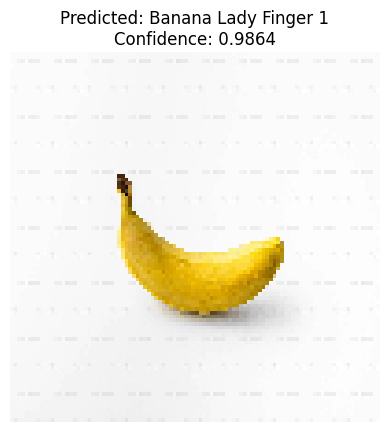

In [25]:
# 1. Load SavedModel
saved_model_dir = "/content/saved_model"   # sesuaikan dengan lokasi SavedModel kamu
inference_model = tf.keras.layers.TFSMLayer(saved_model_dir, call_endpoint='serve')
print("Model SavedModel berhasil di-load.")

# 2. Siapkan mapping index -> nama kelas
class_indices = train_generator.class_indices
idx_to_class = {v: k for k, v in class_indices.items()}

# 3. Upload gambar dari luar dataset
print("Silakan upload 1 gambar (jpg/png) dari luar dataset:")
uploaded = files.upload()

# Ambil nama file pertama yang di-upload
image_path = None
if uploaded:
    image_path = list(uploaded.keys())[0]
    print(f"Gambar yang digunakan untuk inference: {image_path}")
else:
    print("Tidak ada gambar yang di-upload.")

# 4. Lanjutkan hanya jika image_path berhasil didapatkan
if image_path:
    # Load dan preprocessing gambar
    img = image.load_img(image_path, target_size=(img_height, img_width))
    img_array = image.img_to_array(img)
    img_array = img_array / 255.0                 # normalisasi sama seperti saat training
    img_input = np.expand_dims(img_array, axis=0) # shape: (1, h, w, 3)

    # 5. Prediksi
    pred_probs = inference_model(img_input)
    pred_idx = np.argmax(pred_probs[0])
    pred_label = idx_to_class[pred_idx]
    confidence = np.max(pred_probs[0])

    print("\n=== Hasil Inference SavedModel (Gambar Luar Dataset) ===")
    print(f"File gambar   : {image_path}")
    print(f"Predicted     : {pred_label}")
    print(f"Confidence    : {confidence:.4f}")

    # 6. Tampilkan gambar + label prediksi (buat bahan screenshot)
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"Predicted: {pred_label}\nConfidence: {confidence:.4f}")
    plt.show()
else:
    print("Inference tidak dapat dilakukan karena tidak ada gambar yang valid.")